In [1]:
import os
import random
import tqdm
import pandas as pd
from PIL import Image
import torch
import json
import sys

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
img_class_txt = "data/ImageClasses_FSC147.txt"
split_classes_file = "data/Split_Classes_FSC147.json"
split_images_file = "data/Train_Test_Val_FSC_147.json"
split = "test"
img_directory = f"data/images_384_VarV2"
gt_json = "data/gt_cnts_FSC147.json"

img_classes = {}
# Load image classes
with open(img_class_txt, 'r') as file:
    for line in file:
        line = line.strip().split('\t')
        if len(line) == 2:
            img_name, label = line
            img_classes[img_name] = label

# Load split classes and images
with open(split_classes_file, 'r') as f:
    split_classes = json.load(f)

with open(split_images_file, 'r') as f:
    split_images = json.load(f)

# Load GT Counts JSON
with open(gt_json, 'r') as file:
    gt_counts_dict = json.load(file)

random.seed(123)

In [4]:
def create_collage(image1, image2, type):
    # Resize images to be the same size
    width, height = min(image1.size[0], image2.size[0]), min(image1.size[1], image2.size[1])
    if type == "vertical":
        width = height
        height = height // 2
        image1 = image1.resize((width, height))
        image2 = image2.resize((width, height))
        collage = Image.new('RGB', (width, height * 2))
        collage.paste(image1, (0, 0))
        collage.paste(image2, (0, height))
        
    elif type == "horizontal":
        image1 = image1.resize((width, height))
        image2 = image2.resize((width, height))
        collage = Image.new('RGB', (width * 2, height))
        collage.paste(image1, (0, 0))
        collage.paste(image2, (width, 0))
    return collage

def extract_random_img(class_name):
    if class_name == "eggs":
        return "5919.jpg"
    filtered_img_classes = [key for key, value in img_classes.items() if value == class_name]
    img_filename = random.choice(filtered_img_classes)
    return img_filename

def extract_first_img(class_name):
    filtered_img_classes = [key for key, value in img_classes.items() if value == class_name]
    img_filename = filtered_img_classes[0]
    return img_filename

def load_model(model_name):
    if model_name == 'CounTX':
        from models.countx_model import CounTXModel
        model = CounTXModel(img_directory, split_images, split_classes)
        output_prefix = 'CounTX'
    elif model_name == 'CLIP-Count':
        from models.clipcount_model import CLIPCountModel
        model = CLIPCountModel(img_directory, split_images, split_classes)
        output_prefix = 'CLIP-Count'
    elif model_name == 'TFPOC':
        from models.TFPOC_model import ClipSAMModel
        model = ClipSAMModel(img_directory, split_images, split_classes)
        output_prefix = 'TFPOC'
    elif model_name == 'VLCounter':
        from models.vlcounter_model import VLCounterModel
        model = VLCounterModel(img_directory, split_images, split_classes)
        output_prefix = 'VLCounter'
    elif model_name == 'DAVE':
        from models.dave_model import DAVEModel
        model = DAVEModel(img_directory, split_images, split_classes)
        output_prefix = 'DAVE'
    return model

In [ ]:
def mosaic_density_maps(model, mosaic_config, random_neg_image=True):
    random.seed(123)
    random_images_list = []

    output = []

    for config in tqdm.tqdm(mosaic_config):
        img_filename = config[0]
        class_name = config[1]

        img = Image.open(os.path.join(img_directory, img_filename))
        img.load()
        if class_name == img_classes[img_filename]:
            print("WARNING! Positive and negative match!")
        
        if random_neg_image:
            img2_filename = extract_random_img(class_name)
        else:
            img2_filename = extract_first_img(class_name)
        # print(f"Image pos: {img_filename}, Image neg: {img2_filename}, Negative Class: {class_name}")
        random_images_list.append(img2_filename)
        
        img2 = Image.open(os.path.join(img_directory, img2_filename))
        img2.load()
        collage = create_collage(img, img2, type="vertical")

        prompt = model.get_text_prompt(img_classes[img_filename])
        _, density_map_tensor = model.infer(collage, prompt)

        half_height = density_map_tensor.size(dim=0)//2
        upper_density = density_map_tensor[:half_height, :]
        lower_density = density_map_tensor[half_height:, :]

        pred_cnt_up = torch.sum(upper_density).item()
        pred_cnt_low = torch.sum(lower_density).item()
        output.append(
            {'image': collage, 
             'dmap': density_map_tensor.cpu().detach().numpy(),
             'upper_count': pred_cnt_up,
             'lower_count': pred_cnt_low})
    return output

models = ['CounTX', 'CLIP-Count', 'VLCounter', 'TFPOC', 'DAVE']

# the ones used in the paper
#mosaic_config = [("2.jpg", "elephants"), ("2.jpg", "eggs"), ("298.jpg", "eggs")]
#random_neg_image = True

# the ones used in the supplementary
# mosaic_config = [("351.jpg", "keyboard keys"), ("351.jpg", "eggs"),
#                  ("680.jpg", "eggs"), ("680.jpg", "sunglasses"),
#                  ("701.jpg", "sunglasses"), ("701.jpg", "potato chips"),
#                  ("904.jpg", "potato chips"), ("904.jpg", "keyboard keys"),]

mosaic_config = [("351.jpg", "red beans"), ("351.jpg", "candy pieces"),
                 ("680.jpg", "candy pieces"), ("680.jpg", "marbles"),
                 ("701.jpg", "marbles"), ("701.jpg", "skis"),
                 ("904.jpg", "skis"), ("904.jpg", "sauce bottles"),]
random_neg_image = False

# mosaic_config = [("2.jpg", class_name) for class_name in split_classes[split] if class_name != "sea shells"]

imgs_and_dmaps_dict = {}
for model_name in models:
    model = load_model(model_name)
    dmaps = mosaic_density_maps(model, mosaic_config, random_neg_image=random_neg_image)
    imgs_and_dmaps_dict[model_name] = dmaps
    # model_library_path = [line for line in sys.path if model_name in line]
    # if len(model_library_path) > 0:
    #     sys.path.remove(model_library_path[0])

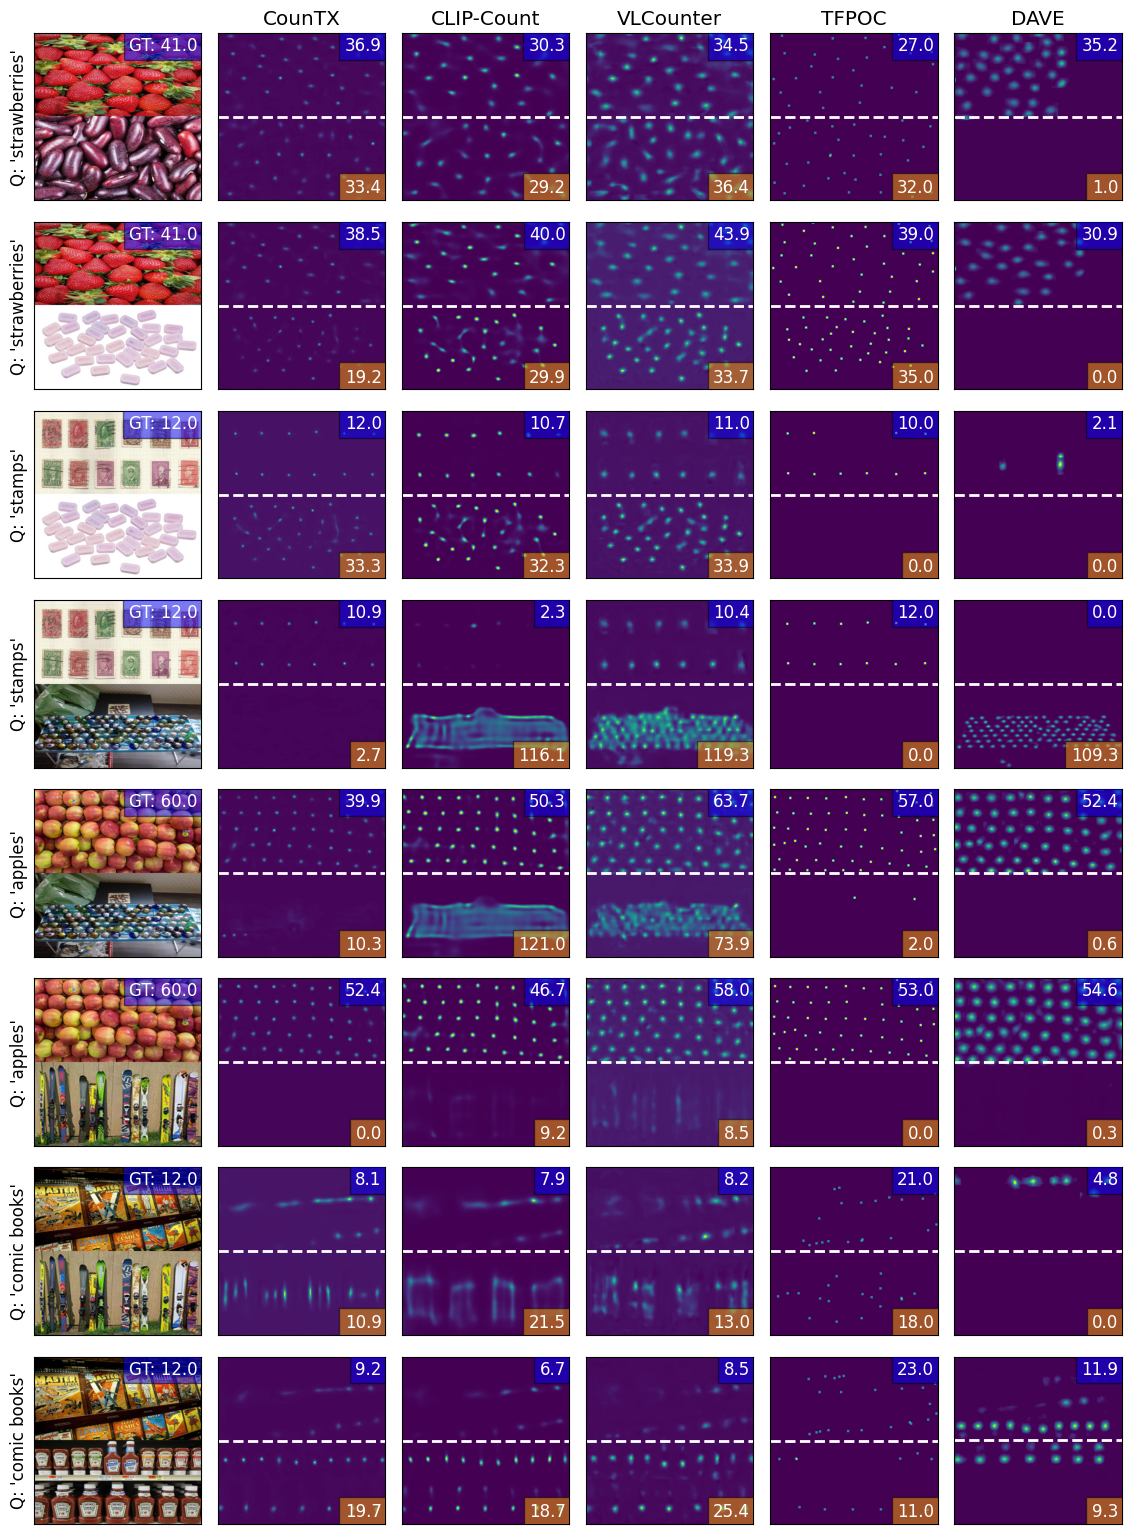

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

# Create a figure with the specified layout
fig, axs = plt.subplots(len(mosaic_config), len(models) + 1, figsize=(12, 2*len(mosaic_config)))

text_margin = 0.02

# Iterate over the mosaic_config
for i, config in enumerate(mosaic_config):
    img_filename, class_name = config
    positive_class = img_classes[img_filename]
    
    # Get the original image
    img = imgs_and_dmaps_dict[models[0]][i]['image']

    # get the groud truth count
    gt_count = gt_counts_dict[img_filename]

    # Plot the original image in the first column
    axs[i, 0].imshow(img)
    # if i == 0:
    #     axs[i, 0].set_title(f"Original")

    axs[i, 0].text(1.0 - text_margin, 1.0 - text_margin, f"GT: {gt_count:.1f}", clip_on=True, color='white', fontsize=12, ha='right', va='top', transform=axs[i, 0].transAxes, bbox=dict(facecolor='blue', alpha=0.5))
    axs[i, 0].set_ylabel(f"Q: '{positive_class}'")
    
    # Iterate over the models
    for j, model_name in enumerate(models):
        # Get the density map for the current model
        dmap = imgs_and_dmaps_dict[model_name][i]['dmap']

        # place a horizontal line in the middle of the image
        axs[i, j+1].axhline(dmap.shape[1]//2, color='white', linestyle='--', linewidth=2)
        
        # Plot the density map in the corresponding column
        axs[i, j+1].imshow(dmap, cmap='viridis')

        # In the upper right corner, display the upper_count
        upper_count = max(0, imgs_and_dmaps_dict[model_name][i]['upper_count'])
        axs[i, j+1].text(1.0 - text_margin, 1.0 - text_margin, f"{upper_count:.1f}", clip_on=True, color='white', fontsize=12, ha='right', va='top', transform=axs[i, j+1].transAxes, bbox=dict(facecolor='blue', alpha=0.5))

        # In the lower right corner, display the lower_count
        lower_count = max(0, imgs_and_dmaps_dict[model_name][i]['lower_count'])
        axs[i, j+1].text(1.0 - text_margin, 0.0 + text_margin, f"{lower_count:.1f}", clip_on=True, color='white', fontsize=12, ha='right', va='bottom', transform=axs[i, j+1].transAxes, bbox=dict(facecolor='orange', alpha=0.5))

        if i == 0:
            axs[i, j+1].set_title(f"{model_name}")

# Adjust the spacing between subplots
plt.tight_layout()

# Remove the x and y ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.1, hspace=0)

# Show the figure
plt.savefig("qualitative_mosaics.pdf")
plt.show()

In [ ]:
def negative_density_maps(model, img_filename, neg_classes):
    img = Image.open(os.path.join(img_directory, img_filename))
    img.load()
    # reshape to 384x384
    img = img.resize((384, 384))
    dmaps = []
    cnts = []
    for class_name in tqdm.tqdm(neg_classes):
        prompt = model.get_text_prompt(class_name)
        positive_class = img_classes[img_filename]
        positive_prompt = model.get_text_prompt(positive_class)
        prompt = model.get_text_prompt(class_name)
        if 'DAVE' in model.model_name:
            _, density_map_tensor = model.infer(img, text=prompt, text_positive=positive_prompt)
        else:
            _, density_map_tensor = model.infer(img, prompt)
        cnt = torch.sum(density_map_tensor).item()
        dmaps.append(density_map_tensor.cpu().detach().numpy())
        cnts.append(cnt)

    return {
        'dmaps': dmaps,
        'cnts': cnts
    }

# neg_classes = ["eggs", "elephants", "keyboard keys", "sunglasses"]
neg_classes = ["sea shells", "sauce bottles", "skis", "potato chips"]

# hot air balloons,strawberries,stamps,watches,apples,comic books,sheep,markers,keyboard keys,carrom board pieces,elephants,sunglasses,deers,crab cakes,cashew nuts,finger foods,green peas,red beans,candy pieces,marbles,potato chips,skis,tree logs,eggs,sauce bottles,sticky notes,nail polish,legos

img_name = "6901.jpg"
neg_dmaps_dict = {}
for model_name in models:
    model = load_model(model_name)
    dmaps = negative_density_maps(model, img_name, neg_classes)
    neg_dmaps_dict[model_name] = dmaps

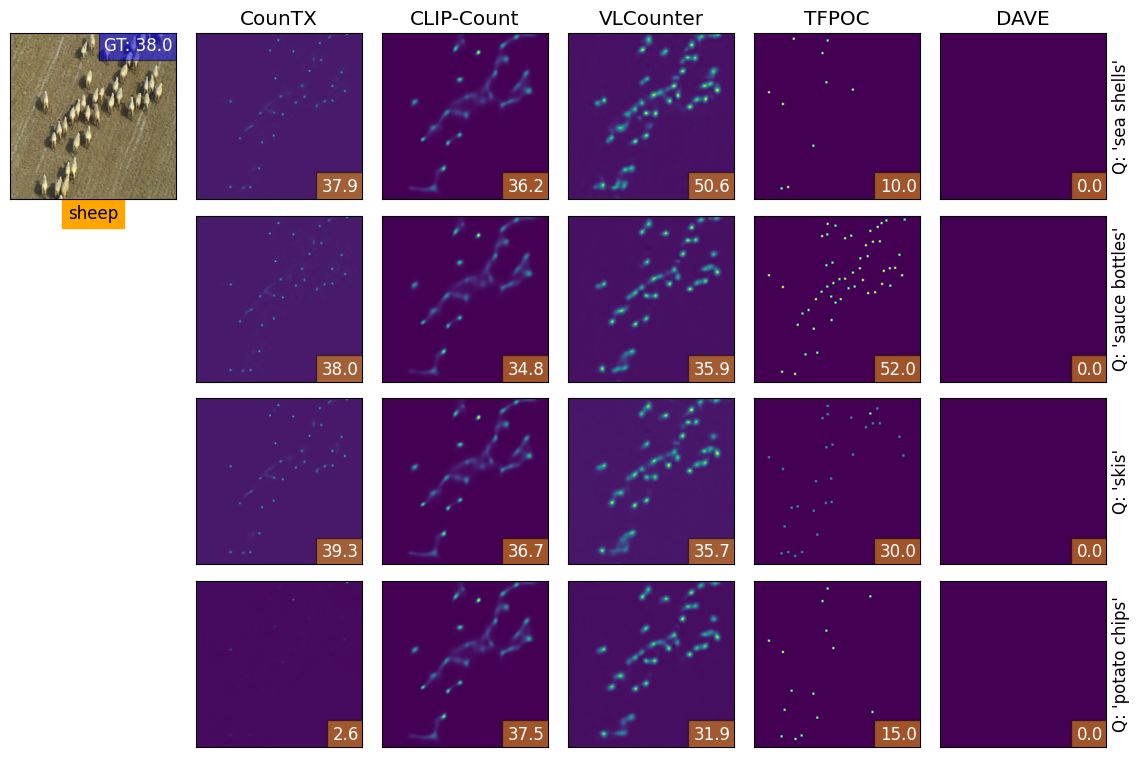

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

# Create a figure with the specified layout
fig, axs = plt.subplots(len(neg_classes), len(models) + 1, figsize=(12, 2*len(neg_classes)))

text_margin = 0.02

# get original image
img = Image.open(os.path.join(img_directory, img_name))
img.load()
# reshape to 384x384
img = img.resize((384, 384))
axs[0, 0].imshow(img)

# get the groud truth count
gt_count = gt_counts_dict[img_name]

# get the positive class
positive_class = img_classes[img_name]

axs[0, 0].text(1.0 - text_margin, 1.0 - text_margin, f"GT: {gt_count:.1f}", clip_on=True, color='white', fontsize=12, ha='right', va='top', transform=axs[0, 0].transAxes, bbox=dict(facecolor='blue', alpha=0.5))
axs[0, 0].set_xlabel(f"{positive_class}", backgroundcolor='orange', color='black')

# Iterate over the models
for j, model_name in enumerate(models):
    # Get the density map for the current model
    dmaps = neg_dmaps_dict[model_name]['dmaps']
    cnts = neg_dmaps_dict[model_name]['cnts']

    # Iterate over negative classes and dmaps
    for i, (neg_class, dmap, cnt) in enumerate(zip(neg_classes, dmaps, cnts)):    
        
        # Plot the density map in the corresponding column
        axs[i, j+1].imshow(dmap, cmap='viridis')
        # print(dmap.shape)

        # In the lower right corner, display the lower_count
        axs[i, j+1].text(1.0 - text_margin, 0.0 + text_margin, f"{cnt:.1f}", clip_on=True, color='white', fontsize=12, ha='right', va='bottom', transform=axs[i, j+1].transAxes, bbox=dict(facecolor='orange', alpha=0.5))

        if i == 0:
            axs[i, j+1].set_title(f"{model_name}")

        if j == len(models) - 1:
            axs[i, j+1].yaxis.set_label_position("right")
            axs[i, j+1].set_ylabel(f"Q: '{neg_class}'")

for i in range(1, len(neg_classes)):
    axs[i, 0].set_visible(False)


# Adjust the spacing between subplots
plt.tight_layout()

# Remove the x and y ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the figure
plt.savefig(f"{img_name}_negative_mosaics.pdf")
plt.show()